<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/N2_O2_CO2_NVT_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#@title Imports & Utils

!pip install jax-md

import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax
from jax import ops

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

In [2]:
N = 400
dimension = 2
box_size = quantity.box_size_at_number_density(N, 0.8, 2)
dt = 5e-3
displacement, shift = space.periodic(box_size) 

kT = lambda t: np.where(t < 5000.0 * dt, 0.1, 0.01)

In [3]:
key = random.PRNGKey(0)

In [27]:
key, split = random.split(key)
R = box_size * random.uniform(split, (N, dimension), dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 5)
N_3 = int(N / 10)

# species = np.where(np.arange(N) < N_2, 0, 1)

# species = np.where((np.arange(N) < N_2) & (np.arange(N) > N_3), 0, 1)

buf = 0
buf_lst = []
for i in range(0, N):

  if buf < N_2:
    buf_lst.append(0)
  elif buf < N_3:
    buf_lst.append(1)
  else:
    buf_lst.append(2)

In [28]:
species = np.array(buf_lst)

In [30]:
energy_fn = energy.soft_sphere_pair(displacement, species=species, sigma=sigma)

init, apply = simulate.nvt_nose_hoover(energy_fn, shift, dt, kT(0.))
state = init(key, R)

In [31]:
write_every = 100

def step_fn(i, state_and_log):
  state, log = state_and_log

  t = i * dt

  # Log information about the simulation.
  T = quantity.temperature(state.velocity)
  log['kT'] = log['kT'].at[i].set(T)
  H = simulate.nvt_nose_hoover_invariant(energy_fn, state, kT(t))
  log['H'] = log['H'].at[i].set(H)
  # Record positions every `write_every` steps.
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: \
                             p.at[i // write_every].set(state.position),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, kT=kT(t))
  
  return state, log

In [ ]:
steps = 10000

log = {
    'kT': np.zeros((steps,)),
    'H': np.zeros((steps,)),
    'position': np.zeros((steps // write_every,) + R.shape) 
}

state, log = lax.fori_loop(0, steps, step_fn, (state, log))

R = state.position

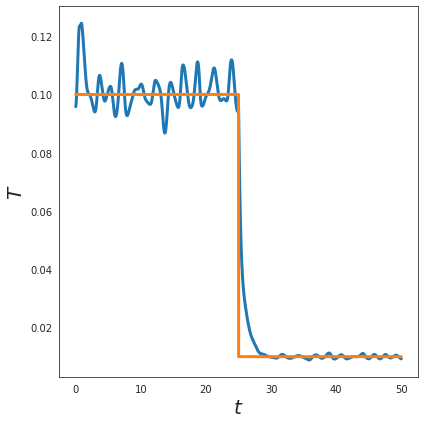

In [23]:
t = onp.arange(0, steps) * dt
plt.plot(t, log['kT'], linewidth=3)
plt.plot(t, kT(t), linewidth=3)
format_plot('$t$', '$T$')
finalize_plot()

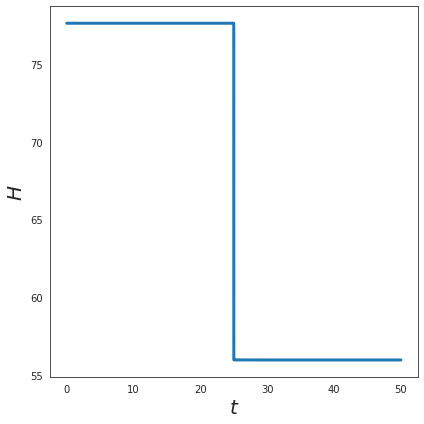

In [24]:
plt.plot(t, log['H'], linewidth=3)
format_plot('$t$', '$H$')
finalize_plot()

In [25]:
from jax_md.colab_tools import renderer

diameters = sigma[species, species]
colors = np.where(species[:, None], 
                  np.array([[1.0, 0.5, 0.01]]), 
                  np.array([[0.35, 0.65, 0.85]]))

renderer.render(box_size,
                {
                    'particles': renderer.Disk(log['position'], 
                                               diameters,
                                               colors)
                },
                resolution=(700, 700))